<img src="images/satrday-cover.png" width="700">


### George Mount
### Stringfest Analytics
### [stringfestanalytics.com](https://georgejmount.com)

# Objectives for today

- Why "R-Powered Excel?"
- A tour of the landscape
- Write a formatted data frame, plot and regression results to a workbook
- Split a data frame by level and write each to a workbook
- Resources for future learning

# Follow along!

Run this notebook on Binder at the [GitHub repo](https://github.com/stringfestdata/satrday-r-powered-excel). *It could take a while to build...*

## R, Excel and the "data analytics stack"


<img src="images/data-analytics-stack.png" width="400">


Source: ["The Data Products Venn Diagram," Data Community DC](https://www.datacommunitydc.org/blog/2013/09/the-data-products-venn-diagram)

# CRAN does not disappoint for R/Excel interfaces:

- `gdata` (Perl required)
- `readxl` 
- `openxlsx` 
- `writexls` (Perl required)
- `XlConnect` (rJava required)
- `xlsx` (rJava required)
- `excel.link`
- etc...


## For most features with fewest external dependencies go with...

- `readxl`: A *read-only* Excel package from the `tidyverse`
- `openxlsx`: Full-service "R-powered Excel"  (The focus of this workshop)

# The basic workflow:

- Create a blank workbook with `createWorkbook()`
- Add worksheets with `addWorksheet()`
- Add various data frames, plots, summaries, etc.
- Save workbook with `saveWorkbook()`

Let's give it a spin with the `mpg` dataset:

In [1]:
# To interface with Excel
library(openxlsx)
# For data manipulation & visualization
library(tidyverse)
# For "tidying" regression output
library(broom)

mpg <- read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/mpg.csv')

head(mpg)

Warning message:
"package 'openxlsx' was built under R version 4.0.3"
Warning message:
"package 'tidyverse' was built under R version 4.0.3"
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

Warning message:
"package 'tibble' was built under R version 4.0.3"
Warning message:
"package 'readr' was built under R version 4.0.3"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'broom' was built under R version 4.0.3"

-- Column specification ------------------------------------------------------------------------------------------------
cols(
  mpg = col_double(),
  cylinders = col_double(),
  displacemen

mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
18,8,307,130,3504,12.0,70,usa,chevrolet chevelle malibu
15,8,350,165,3693,11.5,70,usa,buick skylark 320
18,8,318,150,3436,11.0,70,usa,plymouth satellite
16,8,304,150,3433,12.0,70,usa,amc rebel sst
17,8,302,140,3449,10.5,70,usa,ford torino
15,8,429,198,4341,10.0,70,usa,ford galaxie 500


### The `data` worksheet

First we'll set up objects referring to our workbook and worksheet, respectively. 

In [2]:
# Add workbook
wb <- createWorkbook()

# Add worksheet of raw data
data_sheet <- addWorksheet(wb, sheetName = 'data')

Next, we'll use the `writeDataTable()` function to write `mpg` to this worksheet as an Excel table. 

In [3]:
# Exclude row names
writeDataTable(wb, sheet = data_sheet, x = mpg, rowNames = FALSE)

Pretty much anything you could do to a workbook from Excel, you can do from `openxlsx`. 

For example, let's apply conditional formatting to the `name` column for observations starting with the phrase `ford`:

In [4]:
# Create conditional formatting style
fordStyle <- createStyle(fontColour = "#006100", bgFill = "#C6EFCE")

conditionalFormatting(wb, sheet = data_sheet, 
                  # Find the index position of weight
                  cols = which(colnames(mpg) == 'name'),
                  # Format from rows 2 through the end of mpg (account for header)
                  rows = 2:(nrow(mpg) + 1),
                  # What type of rule is this?
                  type = 'beginsWith',
                  # What is the rule?
                  rule = 'ford',
                  # Apply style
                  style = fordStyle)

### The `analysis` worksheet

I would also like to include an `analysis` worksheet including regression results and a scatterplot of the relationship between `mpg` and `weight`. 

We can set up a new worksheet, add the results of the regression with `writeData()` and add the scatterplot with `writePlot()` 

In [5]:
# Set up a new worksheet 
analysis_sheet <- addWorksheet(wb, sheetName = 'analysis')

In [6]:
# Build a tidy lm regression output
mpg_lm <- lm(mpg ~ weight, data = mpg)
mpg_lm_tidy  <-  tidy(mpg_lm)

mpg_lm_tidy

# Add the table to this worksheet
writeDataTable(wb, sheet = analysis_sheet, x = mpg_lm_tidy, rowNames = FALSE)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),46.31736442,0.7952452295,58.24287,2.753438e-196
weight,-0.00767661,0.0002574869,-29.81360,2.972800e-103


`geom_smooth()` using formula 'y ~ x'



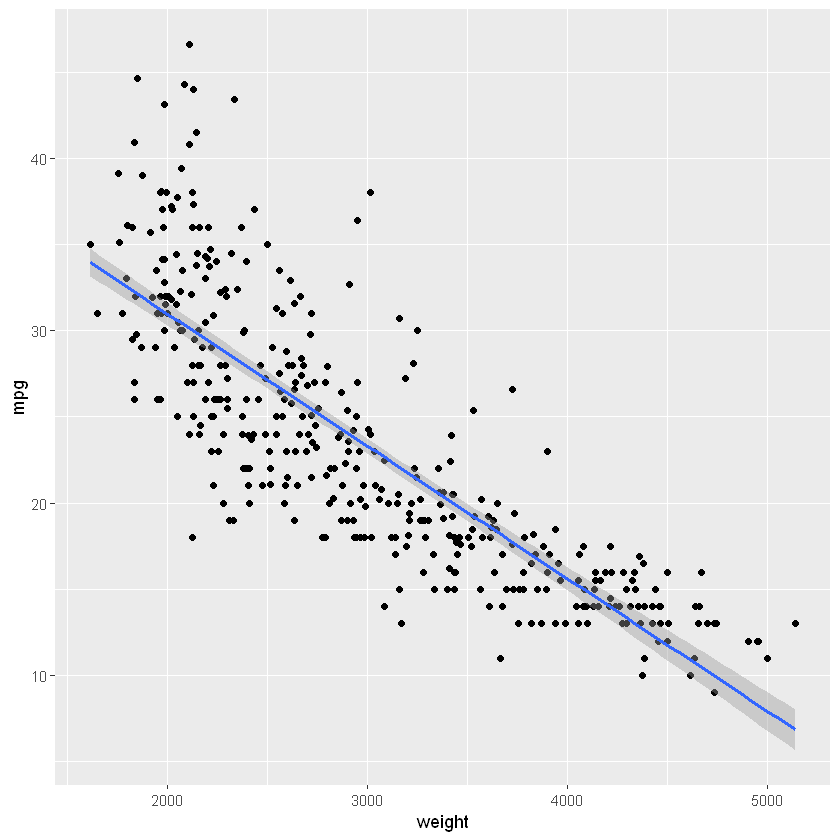

In [7]:
# Visualize the results
ggplot(data = mpg, aes(x = weight, y = mpg))+
    geom_point()+
    geom_smooth(method = 'lm')

# Add the image to the worksheet, set the placement
insertPlot(wb, sheet = analysis_sheet, startRow = 5, startCol = "A", width = 4, height = 4)

### Admire our work, part 1

OK, let's save and view our work. By default, `saveWorkbook()` will put the file in our working directory.

Let's take a look at the finished output in Excel.

In [8]:
mpg_report = 'mpg-report.xlsx'

# save workbook to working directory
saveWorkbook(wb = wb, file = mpg_report, overwrite = TRUE)

It's pretty good! But as a matter of fact I would like to do a few more things to the workbook:

- Freeze panes in each worksheet
- Autofit the column widths in each worksheet
- Format the `weight` column in thousands and `acceleration` with a decimal in the `data` worksheet. 

The connection from R to our workbook is still open in our session; as long as our workbook remains closed, these additinoal changes will be applied to the workbook.

Let's give it a go:

In [9]:
for (sheet in getSheetNames(mpg_report)){
    freezePane(wb, sheet = sheet, firstRow = TRUE)
}

In [10]:
thousands <- createStyle(numFmt = "#,##0")

addStyle(wb, sheet = data_sheet, style = thousands, cols = which(colnames(mpg) == 'weight'), 2:(nrow(mpg) + 1))

In [11]:
setColWidths(wb, sheet = data_sheet, cols = ncol(mpg), widths = "auto")

Let's try this again!

This time, let's use `openXL()` to launch the workbook directly from R.

In [12]:
mpg_report = 'mpg-report.xlsx'

saveWorkbook(wb = wb, file = mpg_report, overwrite = TRUE)

openXL(mpg_report)

### Encore: write to multiple workbooks

Finally, we can write to multiple worksheets by nesting the data frame and then iterating on it. We'll use the `write.xlsx()` function which allows us to write directly to a workbook without defining it.

In [13]:
mpg %>%
  nest(-origin) %>%
  pwalk(~write.xlsx(x = .y, file = paste0(.x, ".xlsx"), asTable = TRUE) )

Warning message:
"All elements of `...` must be named.
Did you want `data = c(mpg, cylinders, displacement, horsepower, weight, acceleration, 
    model_year, name)`?"


# Questions?

# Recommended resources:  



## 1. `browseVignettes()`

In [ ]:
# This takes a while to run in Jupyter...
browseVignettes(package = c('readxl', 'openxlsx'))

## 2. [R & Excel -- LondonR meetup presentation by UBS analysts](https://www.londonr.org/wp-content/uploads/sites/2/presentations/LondonR_-_R_&_Excel_-_David_Jessop_-_20170713.pdf)


![UBS R Excel](images/ubs-r-excel.png)

## 3. In case you're interested in running R on Jupyter:

- Download [Anaconda Individual Edition](https://www.anaconda.com/products/individual)
- Download `IRkernel` package from CRAN ([instructions here](https://irkernel.github.io/installation/))

## 4. In case you're interested in running R on Binder:

- You need a `runtime.txt` file and optionally an `install.R` file
- [Full instructions here](https://github.com/binder-examples/r)

## 4. In case you're interested in "Python-Powered Excel"

- _Python for Excel_ by Felix Zumstein (forthcoming, O'Reilly Media)


![Python for Excel cover](images/python-for-excel.jpg)

# THANK YOU

### George Mount
### Stringfest Analytics
### [stringfestanalytics.com](https://georgejmount.com)
### [linkedin.com/in/gjmount](https://www.linkedin.com/in/gjmount/)
